In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.colors import ListedColormap
import matplotlib.ticker as mtick
import seaborn as sns
from joblib import load
import shap
from mplsoccer.pitch import Pitch, VerticalPitch
from mplsoccer.utils import add_image
from scipy.ndimage import gaussian_filter
from sklearn.inspection import permutation_importance
from sklearn.decomposition import NMF
from PIL import Image
from urllib.request import urlopen
from pdpbox import pdp
from PIL import Image
from urllib.request import urlopen

In [2]:
# Load model and data
cwd = os.getcwd()
df_lgbm = pd.read_parquet(os.path.join(cwd, 'data', 'modelling', 'lgbm2.parquet'))
df_all = pd.read_parquet(os.path.join(cwd, 'data', 'shots.parquet'))
df_X = df_lgbm.drop(['goal', 'split', 'match_id', 'wyscout_id', 'statsbomb_id'], axis=1).copy()
df_xg = pd.read_parquet(os.path.join(cwd, 'data', 'modelling', 'xg_shap2.parquet'))
model = load(os.path.join(cwd, 'models', 'lgbm_model.joblib'))
STATSBOMB = os.path.join(cwd, 'data', 'statsbomb')
df_statsbomb_event = pd.read_parquet(os.path.join(STATSBOMB, 'event.parquet'))
df_statsbomb_freeze = pd.read_parquet(os.path.join(STATSBOMB, 'freeze.parquet'))
df_statsbomb_lineup = pd.read_parquet(os.path.join(STATSBOMB, 'lineup.parquet'))
df_statsbomb_match = pd.read_parquet(os.path.join(STATSBOMB, 'match.parquet'))

In [3]:
# Load StatsBomb logos
logo_regular = np.array(Image.open('SB_Regular.png'))
logo_alt = np.array(Image.open('SB_Regular_Alt.png'))

In [4]:
# Add Jersey number to freeze frame
df_statsbomb_freeze = df_statsbomb_freeze.merge(df_statsbomb_lineup[['match_id', 'player_id', 'player_jersey_number']],
                                                how='left', on=['match_id', 'player_id'], validate='m:1')

In [5]:
# Add on Xg to original shots dataframe
df_all = df_all.merge(df_xg.loc[df_xg.statsbomb_id.notnull(), ['match_id', 'statsbomb_id', 'xg']], how='left')
df_all = df_all.merge(df_xg.loc[df_xg.wyscout_id.notnull(), ['match_id', 'wyscout_id', 'xg']], how='left', 
                      on=['match_id', 'wyscout_id'], suffixes=['', '_1'])
df_all.loc[df_all.xg.isnull(), 'xg'] = df_all.loc[df_all.xg.isnull(), 'xg_1']
df_all.drop(['xg_1'], axis=1, inplace=True)

In [6]:
# Add on StatsBomb xG
df_statsbomb_shots = df_statsbomb_event.loc[df_statsbomb_event.type_name == 'Shot', ['id', 'shot_statsbomb_xg']].copy()
df_statsbomb_shots.rename({'id': 'statsbomb_id'}, axis=1, inplace=True)
df_all = df_all.merge(df_statsbomb_shots, left_on='statsbomb_id', right_on='statsbomb_id', how='left')

In [7]:
# Compare StatsBomb xG and model
df_all['xg_difference'] = df_all.shot_statsbomb_xg - df_all.xg

In [8]:
df_xg_diff = df_all.loc[df_all['xg_difference'].notnull(), ['x', 'y', 'xg_difference']]

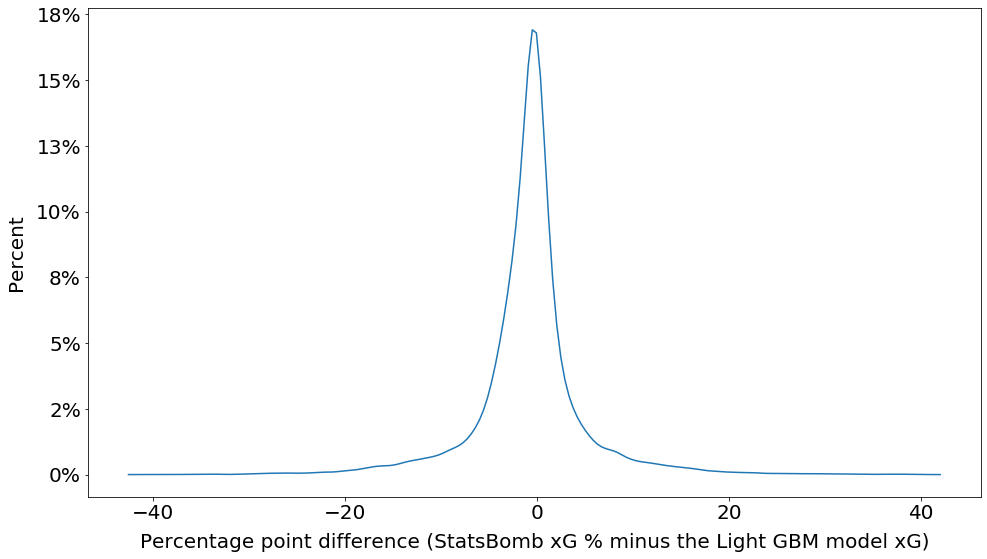

In [9]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.kdeplot(df_all['xg_difference'].values * 100, ax=ax)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
ax.set_ylabel('Percent', fontsize=20, labelpad=10)
ax.set_xlabel('Percentage point difference (StatsBomb xG % minus the Light GBM model xG)', fontsize=20, labelpad=10)
fig.savefig(os.path.join(cwd, 'figures', '23_model_comparison_with_statsbomb_xg_dist'), bbox_inches = 'tight', pad_inches = 0)

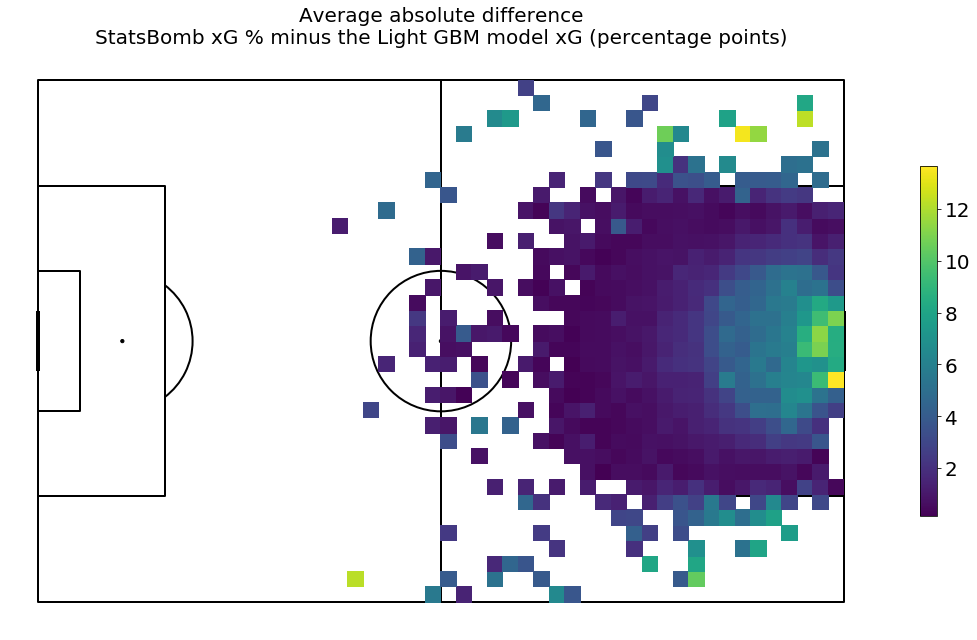

In [10]:
pitch = Pitch(pitch_type='uefa', figsize=(16, 9), line_color='black')
fig, ax = pitch.draw(figsize=(16, 9))
bs = pitch.bin_statistic(df_xg_diff.x, df_xg_diff.y, values=np.abs(df_xg_diff.xg_difference), statistic='mean', bins=(52, 34))
bs['statistic'] = bs['statistic'] * 100.
pcm = pitch.heatmap(bs, ax=ax, cmap='viridis', edgecolors='None')
cbar = fig.colorbar(pcm, fraction=0.045, pad=0.04, shrink=0.6)
cbar.ax.tick_params(labelsize=20)
ax.set_title('Average absolute difference\nStatsBomb xG % minus the Light GBM model xG (percentage points)', fontsize=20)
fig.savefig(os.path.join(cwd, 'figures', '24_model_comparison_with_statsbomb_xg_map'), bbox_inches = 'tight', pad_inches = 0)

# Non-negative matrix facctorisation

In [11]:
# mplsoccer pitch for plotting/ binning data
pitch = VerticalPitch(pitch_type='uefa', half=True,
              pad_left=-5, pad_right=-5, pad_bottom=-10, line_zorder=2)

In [12]:
# Subset shots from players with more than 50 shots
shot_stats = df_all.player_id.value_counts()
player_ids = shot_stats[shot_stats >= 50].index
df_subset = df_all[df_all.player_id.isin(player_ids)].copy()
print('Number of shots:', len(df_subset))
n_players = len(player_ids)
print('Number of players:', n_players)

Number of shots: 28290
Number of players: 302


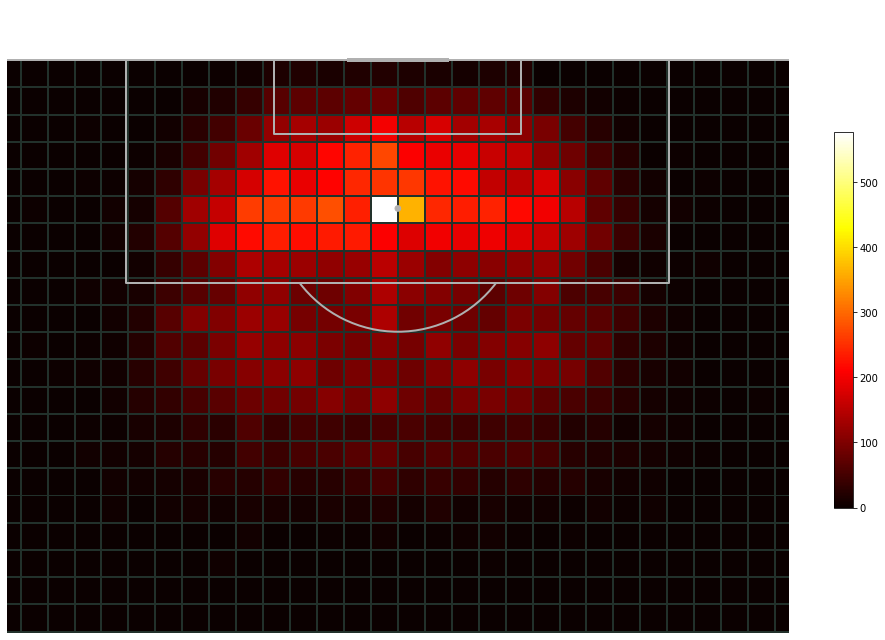

In [13]:
# Overall shot map. Binning approximately 2 metre square grid. Count of shots in each grid cell.
fig, ax = pitch.draw(figsize=(16, 9))
bs = pitch.bin_statistic(df_subset.x, df_subset.y, statistic='count', bins=(52, 34))
pcm = pitch.heatmap(bs, ax=ax, cmap='hot', edgecolors='#22312b')
fig.colorbar(pcm, fraction=0.045, pad=0.04, shrink=0.6)

In [14]:
# Bin Statistics for each player, smoothed with gaussian filter
results = np.zeros((n_players, 34 * 52))
for i in range(n_players):
    df_player = df_subset[df_subset.player_id == player_ids[i]]
    bs = pitch.bin_statistic(df_player.x, df_player.y, statistic='count', bins=(52, 34))
    results[i] = gaussian_filter(bs['statistic'], 1.5).flatten()

In [15]:
# Non-negative matrix factorisation
m = NMF(n_components=5, init='random', random_state=42)
matrix = m.fit_transform(results)
df_matrix = pd.DataFrame(matrix, index=player_ids)
H = m.components_

TypeError: 'AxesSubplot' object is not subscriptable

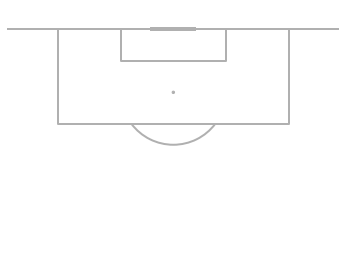

In [16]:
pitch = VerticalPitch(pitch_type='uefa', half=True,
              pad_left=-5, pad_right=-5, pad_bottom=-10, line_zorder=2, figsize=(16, 9),
             layout=(2, 3), tight_layout=False, constrained_layout=True)
fig, axs = pitch.draw()
axs[1, 2].remove()

bs['statistic'] = H[0].reshape(34, 52)
pcm = pitch.heatmap(bs, ax=axs[0, 0], cmap='hot', edgecolors='#22312b', vmin=H.min(), vmax=H.max())

bs['statistic'] = H[1].reshape(34, 52)
pcm = pitch.heatmap(bs, ax=axs[0, 1], cmap='hot', edgecolors='#22312b', vmin=H.min(), vmax=H.max())

bs['statistic'] = H[2].reshape(34, 52)
pcm = pitch.heatmap(bs, ax=axs[0, 2], cmap='hot', edgecolors='#22312b', vmin=H.min(), vmax=H.max())

bs['statistic'] = H[3].reshape(34, 52)
pcm = pitch.heatmap(bs, ax=axs[1, 0], cmap='hot', edgecolors='#22312b', vmin=H.min(), vmax=H.max())

bs['statistic'] = H[4].reshape(34, 52)
pcm = pitch.heatmap(bs, ax=axs[1, 1], cmap='hot', edgecolors='#22312b', vmin=H.min(), vmax=H.max())

cbar = fig.colorbar(pcm, ax=[axs[0, 2]], location='bottom', shrink=0.8)
cbar.ax.tick_params(labelsize=20) 

ax_image = add_image(logo_regular, fig, left=0.69, bottom=0.38, width=0.15, alpha=0.9, interpolation='hanning')

fig.savefig(os.path.join(cwd, 'figures', 'non-negative-matrix-factorization-shot-locations.png'),
            dpi=300, bbox_inches = 'tight', pad_inches = 0)

# Heatmap average xG values

In [17]:
df_all['x_statsbomb'] = df_all['x'] / 105. * 120.
df_all['y_statsbomb'] = 80. - (df_all.y * (80./68.))

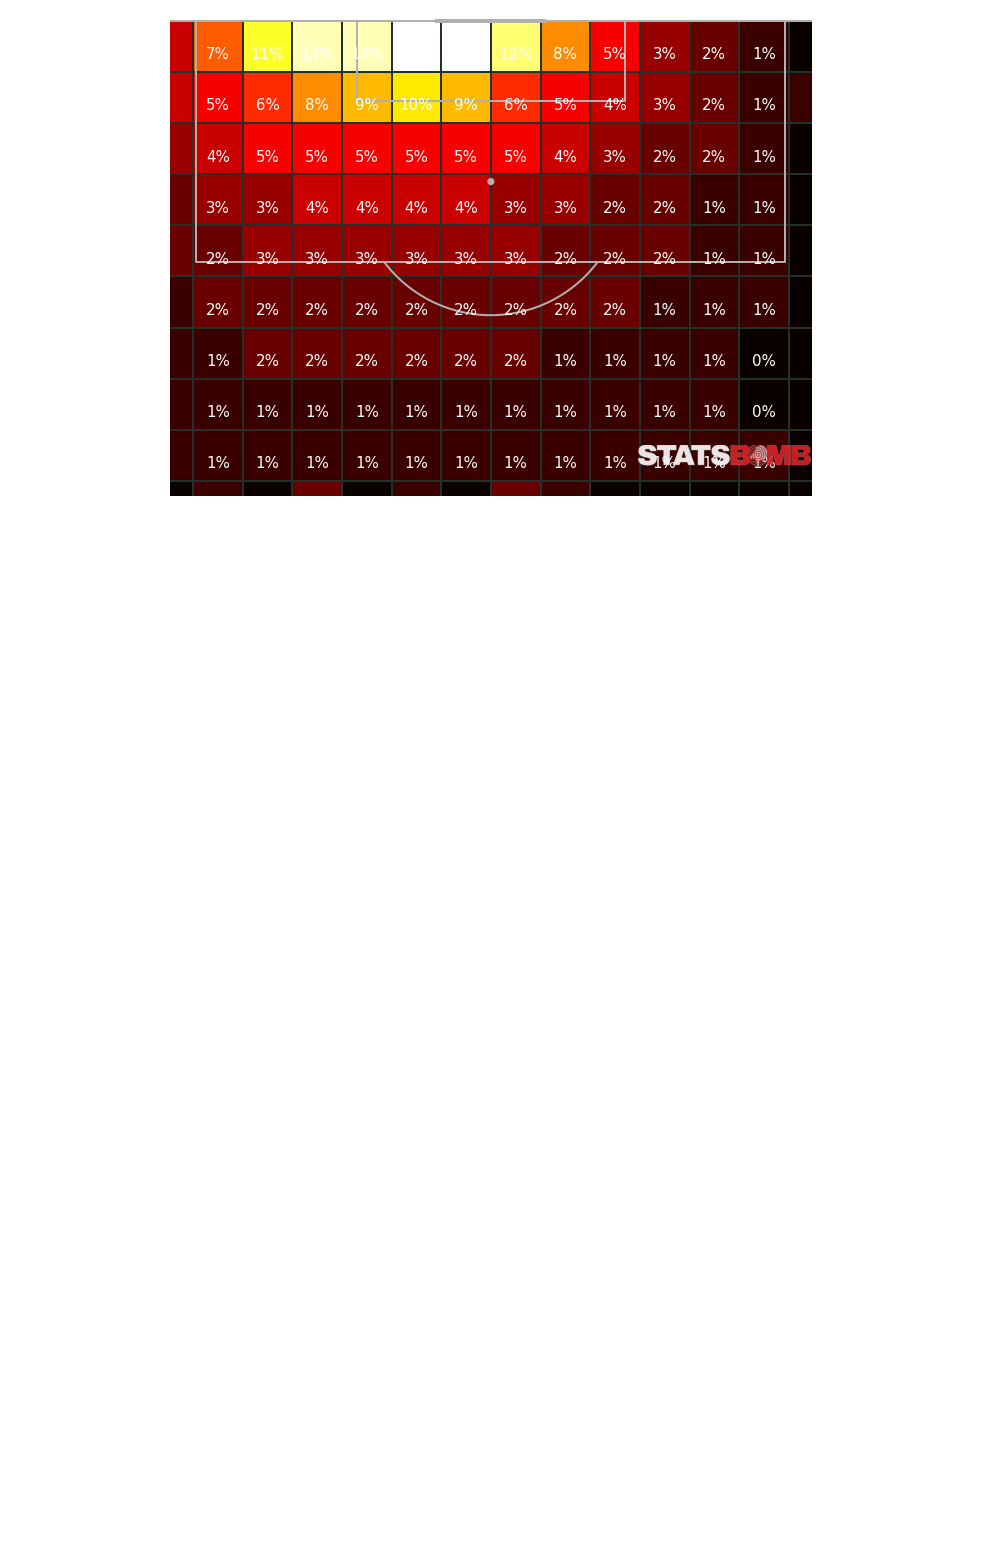

In [18]:
pitch = VerticalPitch(tight_layout=False, pitch_type='uefa', line_zorder=2, half=True, 
              pad_left=-12, pad_right=-12, pad_bottom=-20, pad_top=1)
fig, ax = pitch.draw(figsize=(16, 9))
bs = pitch.bin_statistic(df_all.x_statsbomb, df_all.y_statsbomb, df_all.xg, statistic='mean', bins=(30, 20))
bs['statistic'] = np.round(np.nan_to_num(bs['statistic']) * 100., 0).astype(np.int32)
vmax = bs['statistic'].max()
pcm = pitch.heatmap(bs, ax=ax, cmap='hot', edgecolors='#22312b')
mask = bs['statistic'] > 40
bs['statistic'] = (pd.DataFrame(bs['statistic']).round(0).astype(np.int32).applymap(lambda x: '{:d}%'.format(x)).values)
annotation = pitch.label_heatmap(bs, color='white', fontsize=15, ax=ax, ha='center', va='top', zorder=3)
bs['statistic'][~mask] = ''
annotation = pitch.label_heatmap(bs, color='black', fontsize=15, ax=ax, ha='center', va='top', zorder=3)
ax_image = add_image(logo_alt, fig, left=0.64, bottom=0.17, width=0.15, alpha=0.9, interpolation='hanning')

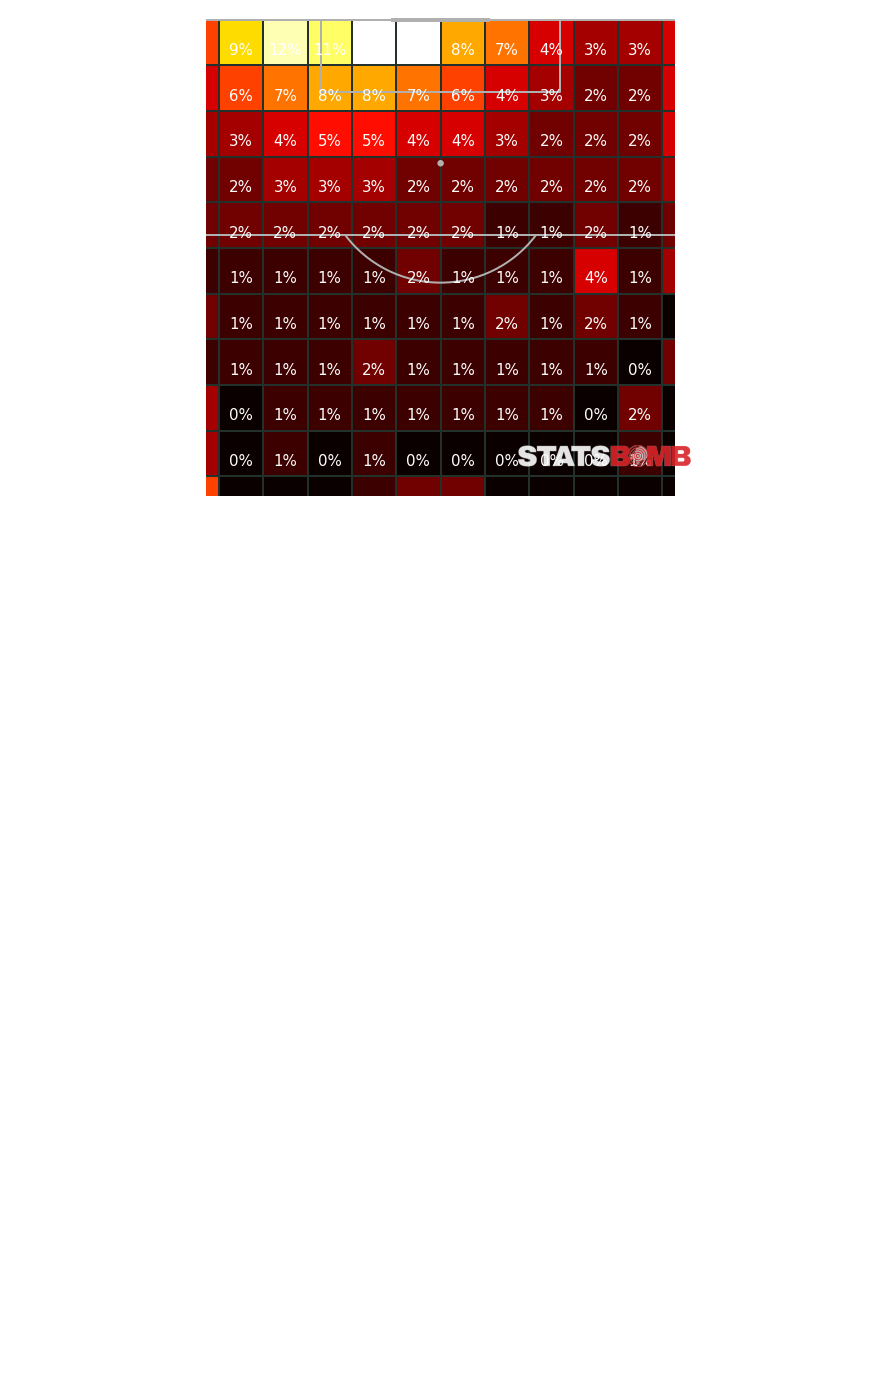

In [19]:
pitch = VerticalPitch(tight_layout=False, pitch_type='uefa', line_zorder=2, half=True,
              pad_left=-16, pad_right=-16, pad_bottom=-16, pad_top=1)
fig, ax = pitch.draw(figsize=(16, 9))
mask_shot = (df_statsbomb_event.type_name == 'Shot') & (df_statsbomb_event.sub_type_name == 'Open Play')
bs = pitch.bin_statistic(df_statsbomb_event[mask_shot].x, df_statsbomb_event[mask_shot].y,
                         df_statsbomb_event[mask_shot].shot_statsbomb_xg,
                         statistic='mean', bins=(30, 20))
bs['statistic'] = np.round(np.nan_to_num(bs['statistic']) * 100., 0).astype(np.int32)
vmax = bs['statistic'].max()
pcm = pitch.heatmap(bs, ax=ax, cmap='hot', edgecolors='#22312b')
mask = bs['statistic'] > 40
bs['statistic'] = (pd.DataFrame(bs['statistic']).round(0).astype(np.int32).applymap(lambda x: '{:d}%'.format(x)).values)
annotation = pitch.label_heatmap(bs, color='white', fontsize=15, ax=ax, ha='center', va='top', zorder=3)
bs['statistic'][~mask] = ''
annotation = pitch.label_heatmap(bs, color='black', fontsize=15, ax=ax, ha='center', va='top', zorder=3)
ax_image = add_image(logo_alt, fig, left=0.58, bottom=0.17, width=0.15, alpha=0.9, interpolation='hanning')
fig.savefig(os.path.join(cwd, 'figures', '25_mean_xg_heatmap.png'), bbox_inches = 'tight', pad_inches = 0)

# Permutation importance

In [20]:
perm_result = permutation_importance(model,
                                     df_X,
                                     df_lgbm.goal,
                                     n_repeats=10,
                                     random_state=42,
                                     n_jobs=-1)

In [21]:
features = df_X.columns
features = np.array([f.replace('_', ' ') for f in features])

df_perm_importance = pd.DataFrame({'Feature': features,
                                   'importance': perm_result.importances.mean(axis=1),
                                   'std_dev': perm_result.importances.std(axis=1)})
df_perm_importance.sort_values('importance', ascending=False, inplace=True)
df_perm_importance.reset_index(drop=True, inplace=True)

In [22]:
df_perm_importance

,Feature,importance,std_dev
0,distance to goal,5.578151e-03,0.000168
1,visible angle,4.696658e-03,0.000253
2,goalkeeper x,8.536567e-04,0.000164
3,body part name,8.010763e-04,0.000229
4,n angle,6.665326e-04,0.000175
5,shot open goal,3.603297e-04,0.000054
6,pass height name,3.417720e-04,0.000088
7,shot type name,2.443438e-04,0.000141
8,shot player number,2.180536e-04,0.000075
9,under pressure,1.531015e-04,0.000056


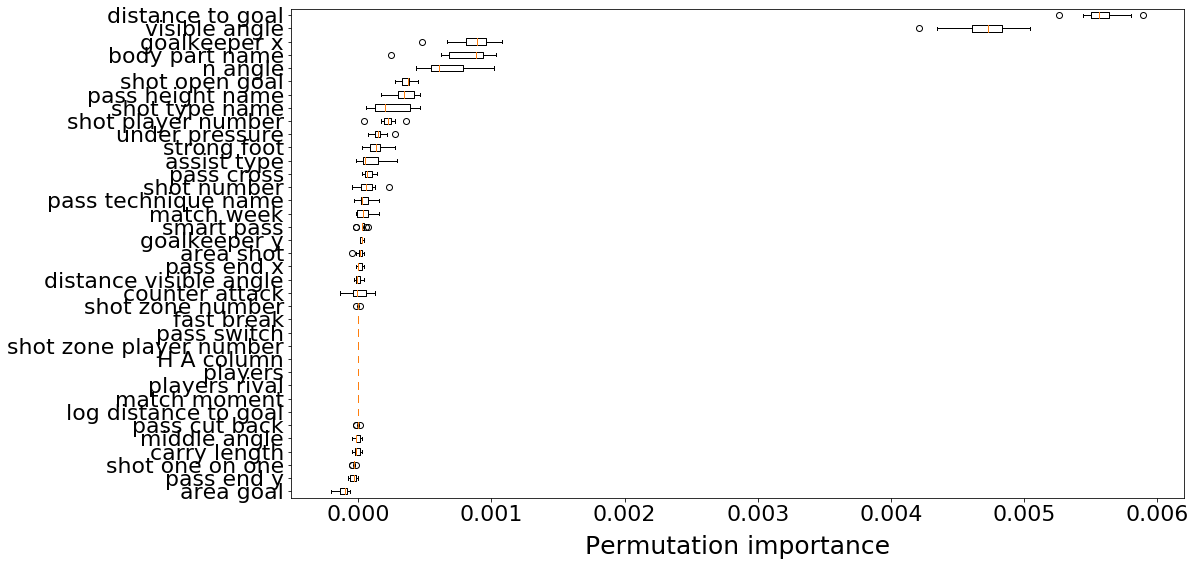

In [23]:
fig, ax = plt.subplots(figsize=(16, 9))
sorted_idx = perm_result.importances_mean.argsort()
box_plot = ax.boxplot(perm_result.importances[sorted_idx].T, vert=False, labels=features[sorted_idx])
ax.tick_params(axis='both', which='major', labelsize=22)
ax.set_xlabel('Permutation importance', labelpad=10, fontsize=25)
fig.savefig(os.path.join(cwd, 'figures', '26_model_perm_importance.png'), bbox_inches = 'tight', pad_inches = 0)

# Partial dependence plots

In [24]:
# Custom grid for partial dependence plots (roughly 1 metres squared)
x = np.linspace(36, 105, 70)
y = np.linspace(0, 68, 69)

In [25]:
# Partial dependence interactions calculations
mask_kick_cross = (df_X.body_part_name.isin([0, 1])) & (df_X.pass_cross == 1)
inter_kick_cross = pdp.pdp_interact(model=model, dataset=df_X[mask_kick_cross], model_features=df_X.columns,
                                    features=['distance_to_goal', 'visible_angle'], cust_grid_points=[x, y], n_jobs=-1,)

In [26]:
mask_other_cross = (df_X.body_part_name == 2) & (df_X.pass_cross == 1)
inter_other_cross = pdp.pdp_interact(model=model, dataset=df_X[mask_other_cross], model_features=df_X.columns,
                                     features=['distance_to_goal', 'visible_angle'], cust_grid_points=[x, y], n_jobs=-1,)

In [ ]:
mask_kick_not_cross = (df_X.body_part_name.isin([0, 1])) & (df_X.pass_cross != 1)
inter_kick_not_cross = pdp.pdp_interact(model=model, dataset=df_X[mask_kick_not_cross], model_features=df_X.columns,
                                        features=['distance_to_goal', 'visible_angle'], cust_grid_points=[x, y], n_jobs=-1,)

In [31]:
# Partial dependence plots
def get_contour_values(inter, col1, col2, len1=len(x), len2=len(y)):
    df_inter = inter.pdp
    X = df_inter[col1].values.reshape((len1, len2)).T
    Y = df_inter[col2].values.reshape((len1, len2)).T
    Z = df_inter.preds.values.reshape((len1, len2)).T
    Z = Z * 100.
    return X, Y, Z

In [32]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)

KeyError: 'x'

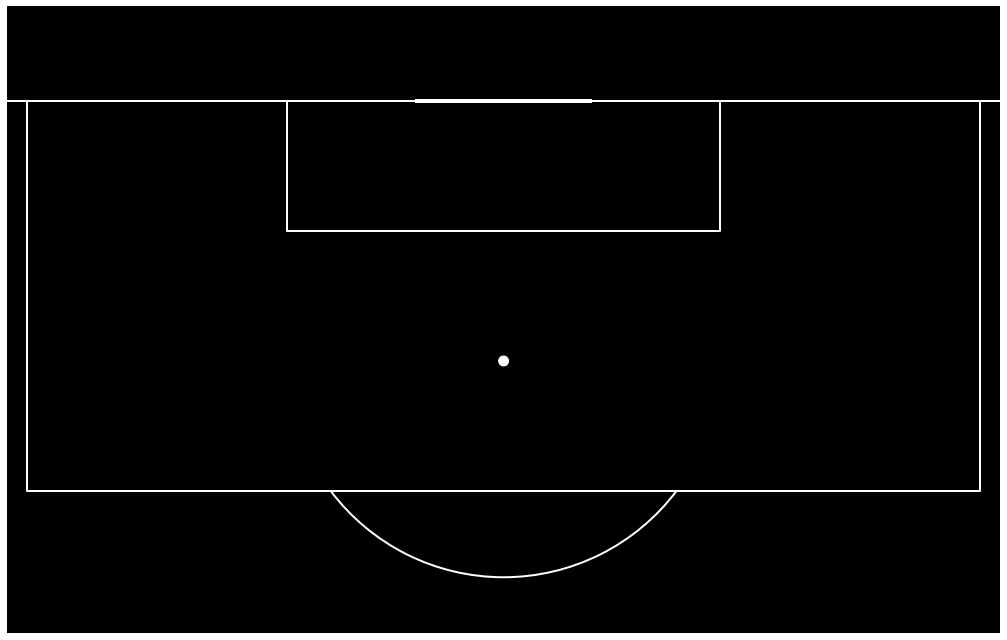

In [33]:
pitch = VerticalPitch(pitch_type='uefa', line_zorder=3, half=True,
             pad_left=-13, pad_bottom=-30, pad_right=-13, line_color='#FFFFFF', pitch_color='black')
fig, ax = pitch.draw(figsize=(16, 9))

levels = np.array([0, 5, 10, 20, 30, 40, 50])
X, Y, Z = get_contour_values(inter_kick_cross, 'x', 'y')
Z = gaussian_filter(Z, 1.5)
contour1 = ax.contour(Y, X, Z, levels=levels, colors='#4fe4e4')
labels1 = ax.clabel(contour1, inline=1, use_clabeltext=True, fmt='%d %%', fontsize=20, colors='#4fe4e4')

X, Y, Z = get_contour_values(inter_kick_not_cross, 'x', 'y')
Z = gaussian_filter(Z, 1.5)
contour2 = ax.contour(Y, X, Z, levels=levels, colors='#d9e04e', linestyles='--')
labels2 = ax.clabel(contour2, inline=1, use_clabeltext=True, fmt='%d %%', fontsize=20, colors='#d9e04e')

h1,_ = contour1.legend_elements()
h2,_ = contour2.legend_elements()
legend = ax.legend([h1[-1], h2[-1]], ['Kick shots assisted by cross', 'Kick shots not assisted by cross'],
                   fontsize=20, frameon=False, loc='upper center')
for text in legend.get_texts():
    text.set_color("white")
    
ax.annotate("            are \nharder to convert", (26.8, 92), (17, 92), 
            arrowprops=dict(arrowstyle="->", lw=3, connectionstyle="angle3,angleA=0,angleB=-45", color='#FFFFFF'),
            va='center', ha='center', color='white', fontsize=20)
ax.annotate("Crosses       \n                 ", (26.8, 92), (17, 92), 
            arrowprops=dict(arrowstyle="->", lw=3, connectionstyle="angle3,angleA=0,angleB=-45", color='#FFFFFF'),
            va='center', ha='center', color='#4fe4e4', fontsize=20)
ax_image = add_image(logo_alt, fig, left=0.75, bottom=0.05, width=0.15, alpha=0.9, interpolation='hanning')
fig.savefig(os.path.join(cwd, 'figures', '27_partial_dependence_probability_scoring_kick_shots.png'),
            bbox_inches = 'tight', pad_inches = 0)

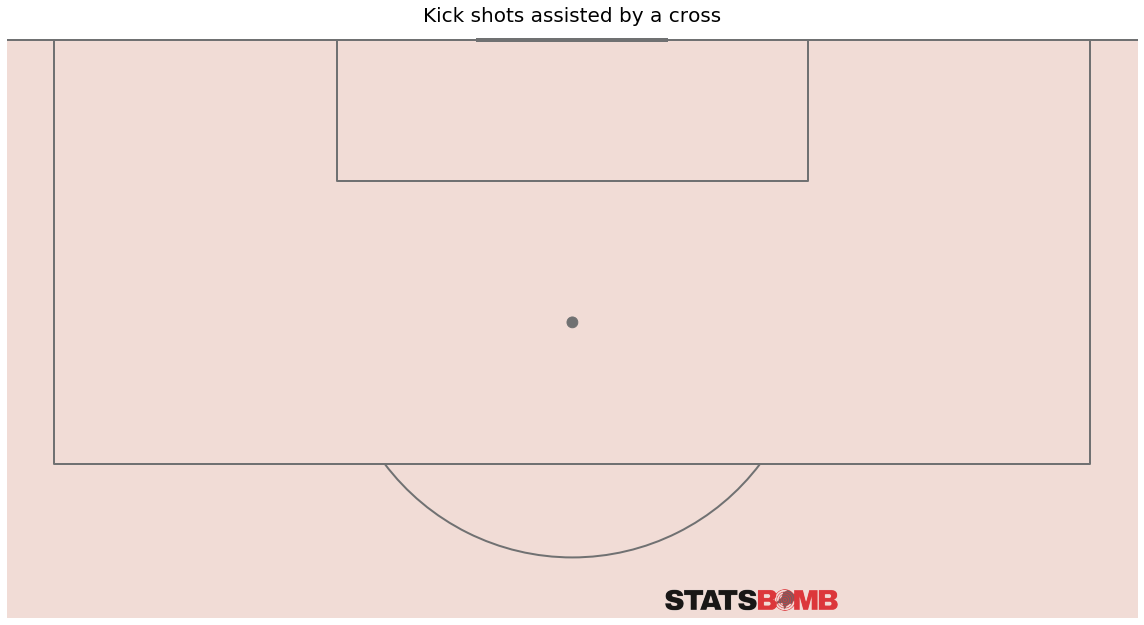

In [35]:
pitch = VerticalPitch(pitch_type='uefa', line_zorder=3, half=True, pad_top=0.5, pad_left=-12, pad_bottom=-30, 
              pad_right=-12, line_color='#707172')
fig, ax = pitch.draw(figsize=(16, 9))
X, Y, Z = get_contour_values(inter_kick_cross, 'distance_to_goal', 'visible_angle')
Z = gaussian_filter(Z, 2)
levels = np.array([0, 5, 10, 20, 30, 40, 50, 100])
contoursf = ax.contourf(Y, X, Z, cmap=cmap, levels=levels, alpha=0.9)
contours = ax.contour(Y, X, Z, levels=levels, colors='black')
labels = ax.clabel(contours, inline=1, use_clabeltext=True, fmt='%d %%', fontsize=20, colors='black')
ax_image = add_image(logo_regular, fig, left=0.58, bottom=0.05, width=0.15, alpha=0.9, interpolation='hanning')
ax.set_title('Kick shots assisted by a cross', fontsize=20, pad=5)
fig.savefig(os.path.join(cwd, 'figures', '28a_partial_dependence_probability_scoring_crosses_kick.png'),
            bbox_inches = 'tight', pad_inches = 0)

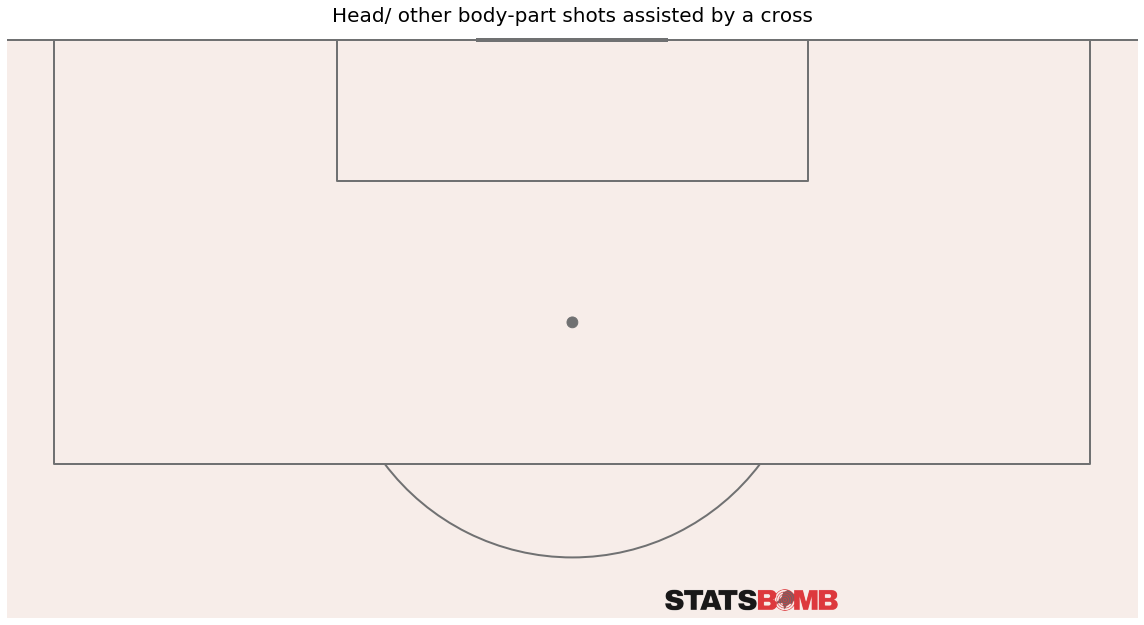

In [36]:
fig, ax = pitch.draw(figsize=(16, 9))
X, Y, Z = get_contour_values(inter_other_cross, 'distance_to_goal', 'visible_angle')
Z = gaussian_filter(Z, 2)
levels = np.array([0, 5, 10, 20, 30, 100])
contoursf = ax.contourf(Y, X, Z, levels=levels, cmap=cmap, alpha=0.9)
contours = ax.contour(Y, X, Z, levels=levels, colors='black')
labels = ax.clabel(contours, inline=1, use_clabeltext=True, fmt='%d %%', fontsize=20, colors='black')
ax.set_title('Head/ other body-part shots assisted by a cross', fontsize=20, pad=5)
ax_image = add_image(logo_regular, fig, left=0.58, bottom=0.05, width=0.15, alpha=0.9, interpolation='hanning')
fig.savefig(os.path.join(cwd, 'figures', '28b_partial_dependence_probability_scoring_crosses_head_other.png'),
            bbox_inches = 'tight', pad_inches = 0)

NameError: name 'inter_kick_not_cross' is not defined

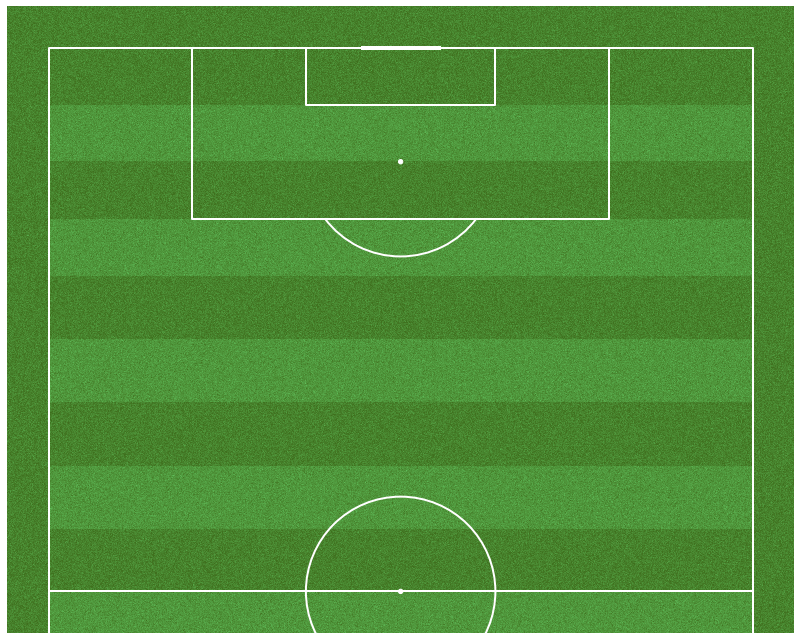

In [38]:
pitch = VerticalPitch(pitch_type='uefa', line_zorder=3, half=True, line_color='#FFFFFF', pitch_color='grass', stripe=True)
fig, ax = pitch.draw(figsize=(16, 9))
levels = np.array([0, 5, 10, 20, 50])
X, Y, Z = get_contour_values(inter_kick_not_cross, 'distance_to_goal', 'visible_angle')
Z = gaussian_filter(Z, 2)
contour2 = ax.contour(Y, X, Z, levels=levels, colors='white', linestyles='-', linewidths=3)
labels2 = ax.clabel(contour2, inline=1, use_clabeltext=True, fmt='%d %%', fontsize=20, colors='white')
ax_image = add_image(logo_regular, fig, left=0.62, bottom=0.1, width=0.15, alpha=0.9, interpolation='hanning')
fig.savefig(os.path.join('..', 'figures', '37_probability_scoring_kick_not_cross.png'),
            bbox_inches = 'tight', pad_inches = 0)

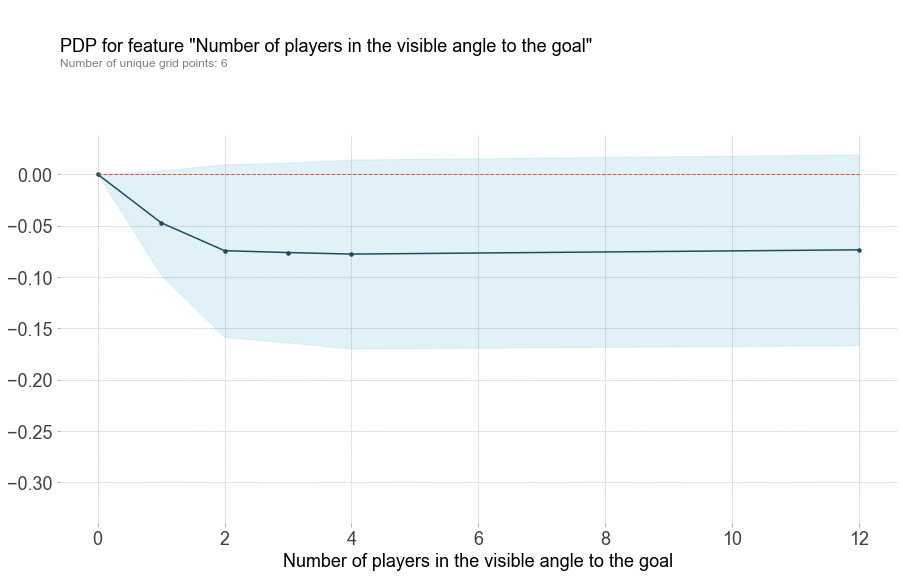

In [40]:
n_angle_isolate = pdp.pdp_isolate(model, dataset=df_X[df_X.n_angle.notnull()],
                                  model_features=df_X.columns, feature='n_angle')
fig, ax = pdp.pdp_plot(n_angle_isolate, 'Number of players in the visible angle to the goal',
                      plot_params={'title_fontsize': 18})
ax['pdp_ax'].tick_params(axis='both', which='major', labelsize=18)
ax['pdp_ax'].set_xlabel('Number of players in the visible angle to the goal', fontsize=18)
fig.savefig(os.path.join(cwd, 'figures', '07_partial_dependence_plot_example.png'), bbox_inches = 'tight', pad_inches = 0)

# Shap values

In [41]:
# Filter only StatsBomb and add goalkeeper id
df_xg = df_xg.loc[df_xg['statsbomb_id'].notnull()].copy()
df_xg = df_xg.merge(df_all.loc[df_all.statsbomb_id.notnull(), ['statsbomb_id','player_id_goalkeeper']],
                    how='left', on='statsbomb_id', validate='1:1')
df_xg.drop('wyscout_id', axis=1, inplace=True)

In [42]:
# Add nickname
df_statsbomb_lineup = df_statsbomb_lineup[['player_id', 'player_nickname', 'player_name']]
df_statsbomb_lineup.sort_values('player_nickname', inplace=True)
mask_nickname = df_statsbomb_lineup.player_nickname.isnull()
df_statsbomb_lineup.loc[mask_nickname, 'player_nickname'] = df_statsbomb_lineup.loc[mask_nickname, 'player_name']
df_statsbomb_lineup.drop_duplicates('player_id', keep='first', inplace=True)
df_statsbomb_lineup.drop('player_name', axis=1, inplace=True)
df_xg = df_xg.merge(df_statsbomb_lineup, left_on='player_id_goalkeeper', right_on='player_id', how='left')

In [43]:
# Dataframe of nicknames
df_statsbomb_event['outcome_name'] = df_statsbomb_event.outcome_name.replace({'Off T': 'Off Target'})

In [44]:
# Add Shap values for goalkeeper position
df_xg['gk_contribution'] = df_xg[['goalkeeper x', 'goalkeeper y']].sum(axis=1).sort_values()

In [45]:
# Sort values by contribution
df_xg.sort_values('gk_contribution', inplace=True)

In [46]:
idx = -4

In [47]:
shot_id = df_xg.iloc[idx].statsbomb_id
df_single_shot = df_statsbomb_event[df_statsbomb_event.id == shot_id].copy()
df_single_shot = df_single_shot.merge(df_statsbomb_lineup, how='left', on='player_id')
df_single_frame = df_statsbomb_freeze[df_statsbomb_freeze.id == shot_id].copy()
df_single_frame = df_single_frame.merge(df_statsbomb_lineup, how='left', on='player_id')

In [48]:
df_teammate = df_single_frame[df_single_frame.player_teammate].copy()
df_gk = df_single_frame[(~df_single_frame.player_teammate) & 
                        (df_single_frame.player_position_name == 'Goalkeeper')].copy()
df_other = df_single_frame[(~df_single_frame.player_teammate) & 
                           (df_single_frame.player_position_name != 'Goalkeeper')].copy()
outcome = df_single_shot.outcome_name.values[0]
team_name = df_single_shot.team_name.values[0]
player_name = df_single_shot.player_nickname.values[0]
if player_name is None:
    player_name = df_single_shot.player_name.values[0]
gk_name = df_gk.player_nickname.values[0]
if gk_name is None:
    gk_name = df_gk.player_name.values[0]
match_id = df_single_shot.match_id.values[0]

In [49]:
home_team = df_statsbomb_match[df_statsbomb_match.match_id == match_id].home_team_name.values[0]
away_team = df_statsbomb_match[df_statsbomb_match.match_id == match_id].away_team_name.values[0]
date = df_statsbomb_match[df_statsbomb_match.match_id == match_id].match_date.values[0].astype('str')[:10]
if home_team == team_name:
    other_team = away_team
else:
    other_team = home_team

In [51]:
df_xg.columns

Index(['match_id', 'statsbomb_id', 'xg', 'shot type name', 'counter attack',
       'fast break', 'strong foot', 'body part name', 'assist type',
       'pass end y', 'pass end x', 'pass switch', 'pass cross',
       'pass cut back', 'pass height name', 'pass technique name',
       'carry length', 'visible angle', 'middle angle', 'distance to goal',
       'distance visible angle', 'log distance to goal', 'shot one on one',
       'shot open goal', 'under pressure', 'match week', 'H A column',
       'players', 'players rival', 'area shot', 'area goal', 'n angle',
       'goalkeeper x', 'goalkeeper y', 'smart pass', 'match moment',
       'shot number', 'shot zone number', 'shot player number',
       'shot zone player number', 'bias', 'player_id_goalkeeper', 'player_id',
       'player_nickname', 'gk_contribution'],
      dtype='object')

In [52]:
df_xg.columns[3:-7].values

array(['shot type name', 'counter attack', 'fast break', 'strong foot',
       'body part name', 'assist type', 'pass end y', 'pass end x',
       'pass switch', 'pass cross', 'pass cut back', 'pass height name',
       'pass technique name', 'carry length', 'visible angle',
       'middle angle', 'distance to goal', 'distance visible angle',
       'log distance to goal', 'shot one on one', 'shot open goal',
       'under pressure', 'match week', 'H A column', 'players',
       'players rival', 'area shot', 'area goal', 'n angle',
       'goalkeeper x', 'goalkeeper y', 'smart pass', 'match moment',
       'shot number', 'shot zone number'], dtype=object)

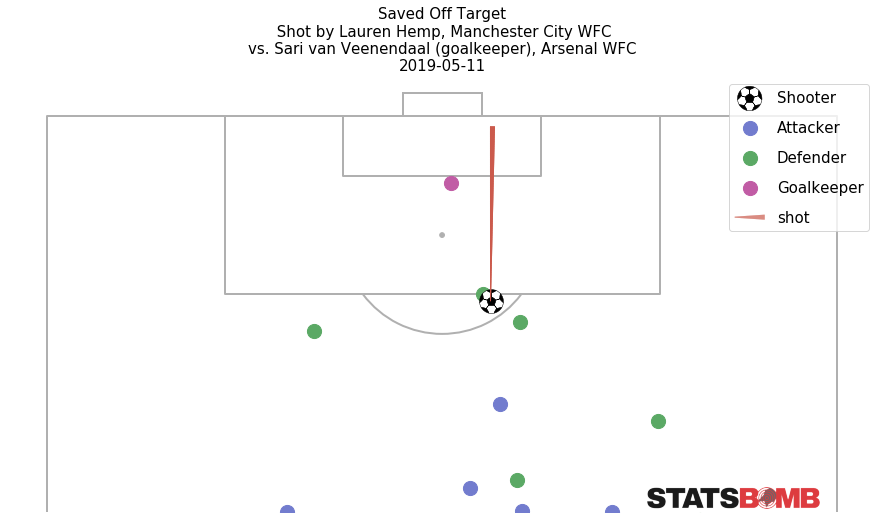

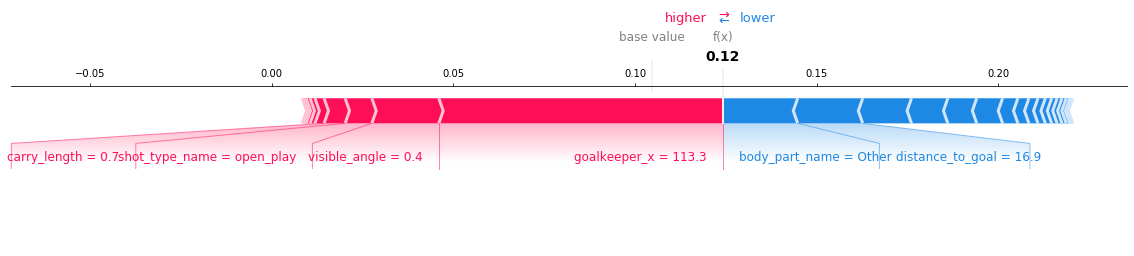

In [53]:
fig, ax = plt.subplots(figsize=(16, 8))
pitch = VerticalPitch(half=True, tight_layout=False, goal_type='box', pad_bottom=-20)
pitch.draw(ax=ax)
ax_image = add_image(logo_regular, fig, left=0.69, bottom=0.13, width=0.15, alpha=0.9, interpolation='hanning')
sc1 = pitch.scatter(df_single_shot.x, df_single_shot.y, marker='football', s=600, ax=ax, label='Shooter', zorder=1.2)
sc2 = pitch.scatter(df_teammate.x, df_teammate.y, s=200, c='#727cce', label='Attacker', ax=ax)
sc3 = pitch.scatter(df_other.x, df_other.y, s=200, c='#5ba965', label='Defender', ax=ax)
sc4 = pitch.scatter(df_gk.x, df_gk.y, s=200, ax=ax, c='#c15ca5', label='Goalkeeper')
line = pitch.lines(df_single_shot.x, df_single_shot.y, 
                   df_single_shot.end_x, df_single_shot.end_y,
                   comet=True, label='shot', color='#cb5a4c', ax=ax)
legend = ax.legend(labelspacing=1, fontsize=15)
title = (f'{outcome}\n Shot by {player_name}, {team_name}\n'
         f'vs. {gk_name} (goalkeeper), {other_team}\n'
         f'{date}')
ax.set_title(title, fontsize=15)
features = df_all.loc[df_all.statsbomb_id == shot_id, df_X.columns]
float_cols = ['distance_to_goal','visible_angle','pass_end_x', 'pass_end_y', 'carry_length', 'area_shot',
              'area_goal', 'n_angle', 'goalkeeper_x', 'goalkeeper_y']
features[float_cols] = features[float_cols].round(1)
shap.force_plot(df_xg.loc[df_xg.statsbomb_id == shot_id, df_xg.columns[-5]].values[0], 
                df_xg.loc[df_xg.statsbomb_id == shot_id, df_xg.columns[3:-5]].values,
                features=features.astype(str),
                feature_names=df_X.columns, matplotlib=True)

In [54]:
df_all.loc[df_all.statsbomb_id == shot_id, ['shot_statsbomb_xg', 'xg', 'xg_difference']]

,shot_statsbomb_xg,xg,xg_difference
6058,0.036488,0.124195,-0.087707


In [55]:
df_xg[df_xg.statsbomb_id == shot_id].gk_contribution

5936    0.078921
Name: gk_contribution, dtype: float64

In [56]:
df_xg = df_xg.merge(df_statsbomb_match[['match_id', 'competition_gender']], on='match_id', how='left')
df_xg.loc[df_xg.competition_gender.isnull(), 'competition_gender'] = 'female'

In [57]:
df_xg['good_position'] = df_xg['gk_contribution'] <= -0.01
df_xg['poor_position'] = df_xg['gk_contribution'] >= 0.05

In [58]:
gk_200_shots = df_xg.player_id.value_counts()[df_xg.player_id.value_counts() >= 200].index
df_xg = df_xg[df_xg.player_id.isin(gk_200_shots)].copy()

In [59]:
gk_contribution = df_xg.groupby(['player_id', 'player_nickname', 'competition_gender'])['good_position', 'poor_position'].mean()
goal_counts = df_xg.groupby(['player_id', 'player_nickname', 'competition_gender']).player_id.count()
df_contribution = pd.DataFrame(gk_contribution).merge(pd.DataFrame(goal_counts), left_index=True, right_index=True)
df_contribution.rename({'player_id': 'shot_count'}, axis=1, inplace=True)
df_contribution.sort_values('good_position', ascending=False, inplace=True)
df_contribution['good_position'] = (df_contribution['good_position'] * 100).round(0)
df_contribution['poor_position'] = (df_contribution['poor_position'] * 100).round(0)
df_contribution.reset_index(drop=False, inplace=True)

In [60]:
df_contribution

,player_id,player_nickname,competition_gender,good_position,poor_position,shot_count
0,26103,Carlos Kameni,male,15.0,0.0,233
1,16376,Sophie Baggaley,female,15.0,0.0,592
2,6576,Gorka Iraizoz,male,14.0,0.0,256
3,4691,Claudio Bravo,male,13.0,0.0,684
4,15576,Kirstie Levell,female,13.0,0.0,263
5,15719,Grace Moloney,female,13.0,0.0,336
6,19419,Marie Hourihan,female,13.0,0.0,213
7,6768,Diego López,male,12.0,0.0,218
8,5597,Keylor Navas,male,12.0,0.0,213
9,20055,Marc-André ter Stegen,male,12.0,0.0,1423
